In [1]:
import gym
env_name = 'CartPole-v0'
env = gym.make(env_name)

d:\Miniconda\envs\cs285\lib\site-packages\gym\envs\registration.py:594: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
d:\Miniconda\envs\cs285\lib\site-packages\gym\core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
d:\Miniconda\envs\cs285\lib\site-packages\gym\wrappers\step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviou

In [2]:
env.action_space

Discrete(2)

In [3]:
env

<TimeLimit<OrderEnforcing<StepAPICompatibility<PassiveEnvChecker<CartPoleEnv<CartPole-v0>>>>>>

In [4]:
env.action_space.sample()

1

In [5]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [6]:
done = False
state = env.reset()
score = 0

while not done:
    env.render()
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    score += reward

print(f'The total score equals {score}')

d:\Miniconda\envs\cs285\lib\site-packages\gym\core.py:50: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  "You are calling render method, "


The total score equals 18.0


In [7]:
import gym 
import collections
from tqdm import tqdm
import torch
from utils import rl_utils
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

d:\Miniconda\envs\cs285\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define the replay buffer

In [8]:
class ReplayBuffer:
    """Replay Buffer"""
    def __init__(self, capacity) -> None:
        self.buffer = collections.deque(maxlen=capacity)

    def add_value(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        sample = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*sample)
        # print(f'sample state shape: {np.array(state).shape}')
        return torch.tensor(state), action, reward, torch.tensor(next_state), done
    
    def size(self):
        return len(self.buffer)

# Define a neural network with one hidden layer

In [9]:
class Qnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim) -> None:
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


# DQN algorithm

* `item()`可以将tensor转换为标量, 只适用于只有一个元素的时候
* `torch.tensor.gather(1, indices)`，如果tensor的形状为`[batch_size, action_dim]`, 同时indices是索引张量形状为`[batch_size, 1]`, `gather()`之后会得到形状为`[batch_size, 1]`的对应Q值的张量
* `view(-1, 1)`可以快速的使tensor变为列向量
* `tensor.max(0)`的含义是返回第零维度的各元素相比最大的值和对应的indices，`tensor.max(1)`的含义是返回第一维度的各元素相比最大的值和对应的indices

### An example for `gather()`

In [10]:
import torch

# 假设我们有一个 Q 值张量 Q，形状为 (batch_size, num_actions)
Q = torch.tensor([[1.0, 2.0, 3.0],
                  [0.5, 1.5, 2.5]])

# 假设我们有一个索引张量 indices，形状为 (batch_size, 1)
indices = torch.tensor([[0],
                       [2]])

# 使用 gather 函数选择每个样本对应的 Q 值
selected_q_values = Q.gather(1, indices)

print(selected_q_values)

tensor([[1.0000],
        [2.5000]])


### An example for `max(1)[0]`

In [11]:
import torch

# 假设有一个包含2个样本和3个动作的 Q 网络
target_q_net = torch.nn.Linear(3, 3)
next_states = torch.tensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]], dtype=torch.float)

# 使用目标 Q 网络评估下一个状态的 Q 值
q_values = target_q_net(next_states)
print(q_values)

# 找到每个下一个状态的最大 Q 值及其对应的动作索引
max_q_values = q_values.max(1)
print(max_q_values)

# 提取最大 Q 值向量
max_q_values_vector = max_q_values[0]
max_q_values_index = max_q_values[1]
print(max_q_values_vector)
print(max_q_values_index)

# 将最大 Q 值向量从一维变为列向量
max_next_q_values = max_q_values_vector.view(-1, 1)

print(max_next_q_values)

tensor([[-0.3132,  0.4093, -0.0381],
        [-0.6689,  0.2097,  0.1304]], grad_fn=<AddmmBackward0>)
torch.return_types.max(
values=tensor([0.4093, 0.2097], grad_fn=<MaxBackward0>),
indices=tensor([1, 1]))
tensor([0.4093, 0.2097], grad_fn=<MaxBackward0>)
tensor([1, 1])
tensor([[0.4093],
        [0.2097]], grad_fn=<ViewBackward0>)


In [12]:
class DQN:
    """DQN algorithm"""
    def __init__(self, state_dim, hidden_dim, action_dim, epsilon, gamma, lr, device, target_update) -> None:
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        self.q_net = Qnet(self.state_dim, self.hidden_dim, self.action_dim).to(device)
        self.target_q_net = Qnet(self.state_dim, self.hidden_dim, self.action_dim).to(device)
        self.epsilon = epsilon
        self.gamma = gamma
        self.count = 0
        self.device = device
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)
        self.target_update = target_update   

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        
        else:
            state = torch.tensor(data=state, dtype=torch.float, device=self.device)
            action = self.q_net(state).argmax().item()
        return action
    

    def update(self, transition_dict):
        states = torch.tensor(data=transition_dict['states'], dtype=torch.float, device=self.device)
        # print(f'DQN state shape: {np.array(states).shape}')
        actions = torch.tensor(data=transition_dict['actions'], dtype=torch.int64, device=self.device).view(-1, 1)
        rewards = torch.tensor(data=transition_dict['rewards'], dtype=torch.float, device=self.device).view(-1, 1)
        next_states = torch.tensor(data=transition_dict['next_states'], dtype=torch.float, device=self.device)
        dones = torch.tensor(data=transition_dict['dones'], dtype=torch.float, device=self.device).view(-1, 1)
        q_values = self.q_net(states).gather(1, actions)
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1,1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(input=q_values, target=q_targets)) # 要用均方误差
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())

        self.count += 1
        

In [13]:
epsilon = 0.01
gamma = 0.98
lr = 2e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
target_update = 10
hidden_dim = 128

env_name = 'CartPole-v0'
env = gym.make(env_name)
env.reset(seed=0)
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
new_step_api = True
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
num_episodes = 500
buffer_size = 10000
minimal_size = 500
batch_size = 64
replaybuffer = ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, epsilon, gamma, lr, device, target_update)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc=f'Iteration {i}') as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                replaybuffer.add_value(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                if replaybuffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replaybuffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'rewards': b_r,
                        'next_states': b_ns,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
            pbar.update(1)


d:\Miniconda\envs\cs285\lib\site-packages\gym\envs\registration.py:594: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
d:\Miniconda\envs\cs285\lib\site-packages\gym\core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
d:\Miniconda\envs\cs285\lib\site-packages\gym\wrappers\step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviou

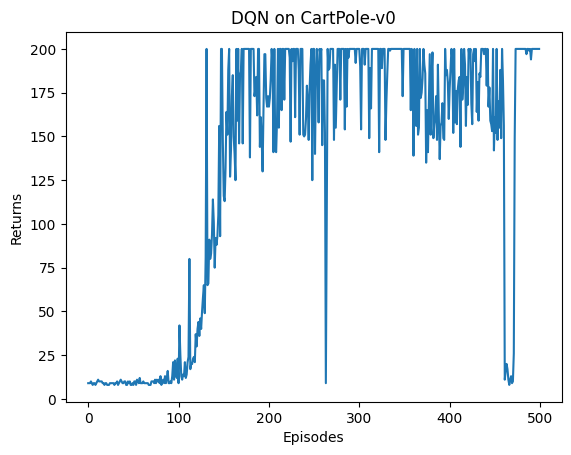

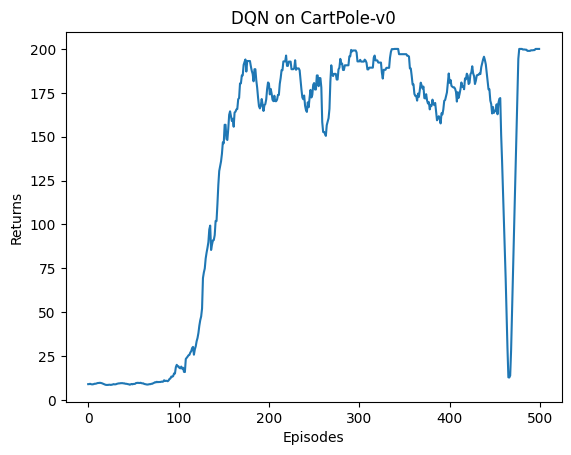

In [14]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()